In [1]:
import jax 
import jax.numpy as jnp
import glob 
import os 
import pandas as pd 
import matplotlib.pyplot as plt 
from ploting import *
jax.config.update("jax_enable_x64", True)

In [2]:
from SHEAP.main_sheap import Sheapectral 
from SHEAP.spectra_readers import parallel_reader 


#####  The idea of this notebook if call the small functions to try to build a logic in the code 

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
path_dr16 = "/home/favila/smbh_mass/dr16"
path_dr16 = "/home/felipe/work/SMBH_estimation/dr16"
Objects_low_stellar_mass_with_stellar_contribution_all = pd.read_csv("Objects_low_stellar_mass_with_stellar_contribution_slope_all_130225.csv")

In [5]:
paths = glob.glob(os.path.join(path_dr16,"bernal_sdss_fits/*.fits"))
dr = pd.read_csv(os.path.join(path_dr16,"Objects_low_stellar_mass_with_stellar_contribution.csv"))# [0:500]
dr["dr_name"] = [f"{PLATE:04d}-{MJD:05d}-{FIBERID:04d}" for PLATE,MJD,FIBERID in dr[["PLATE","MJD","FIBERID"]].values]
dr_paths = [os.path.basename(path).replace(".fits", "") for path in paths]
dr_filtered = dr[dr["dr_name"].isin(dr_paths)].reset_index(drop=True)
dr_filtered["fit_path"] = dr_filtered["dr_name"].apply(lambda x: os.path.join(path_dr16,f"bernal_sdss_fits/{x}.fits")).values
dr_filtered = dr_filtered[[os.path.isfile(fit_path) for fit_path in dr_filtered.fit_path.values]]
#dr_filtered["pyqso_path"] = dr_filtered["dr_name"].apply(lambda x: os.path.join(path_dr16,f"data/op-{x}.fits")).values

coords,spectra_reshaped = parallel_reader(dr_filtered.fit_path.values)
coords = jnp.array(coords)
spectra_reshaped = jnp.array(spectra_reshaped)

/home/felipe/work/SMBH_estimation/SHEAP_developer/SHEAP/spectra_readers.py:13: RuntimeWarning: divide by zero encountered in divide
  aD = np.array([10**hdul[1].data[key] if key == "loglam" else (1 / np.sqrt(hdul[1].data[key]) if key == "ivar" else hdul[1].data[key]) for key in ["loglam", "flux", "ivar"]])
/home/felipe/work/SMBH_estimation/SHEAP_developer/SHEAP/spectra_readers.py:13: RuntimeWarning: divide by zero encountered in divide
  aD = np.array([10**hdul[1].data[key] if key == "loglam" else (1 / np.sqrt(hdul[1].data[key]) if key == "ivar" else hdul[1].data[key]) for key in ["loglam", "flux", "ivar"]])
/home/felipe/work/SMBH_estimation/SHEAP_developer/SHEAP/spectra_readers.py:13: RuntimeWarning: divide by zero encountered in divide
  aD = np.array([10**hdul[1].data[key] if key == "loglam" else (1 / np.sqrt(hdul[1].data[key]) if key == "ivar" else hdul[1].data[key]) for key in ["loglam", "flux", "ivar"]])
/home/felipe/work/SMBH_estimation/SHEAP_developer/SHEAP/spectra_readers.py:1

In [6]:
test_clase = Sheapectral(spectra_reshaped,z=dr_filtered["Z"].values,coords = coords)

In [99]:
from SHEAP.host_sub.start_method import Extract_host_star_new
from SHEAP.fitting.functions import GaussianSum,linear2,combine_auto
from SHEAP.utils import mask_builder
from SHEAP.fitting.main_fitting_I import MasterMinimizer
from jax import vmap 
from SHEAP.tools.others import vmap_get_EQW_mask

In [100]:
    # gauss = GaussianSum(n=1, constraints={})
    # g_c = combine_auto([gauss,linear2])

In [101]:
#/home/felipe/work/SMBH_estimation/SHEAP_developer/SHEAP

In [137]:
spectra_exp

Array(4., dtype=float64)

In [ ]:
plt.plo(jnp.linspace(*outer_limits,1000),g_c(jnp.linspace(*outer_limits,1000),params_g[0]))

(3908.0, 3960.0)

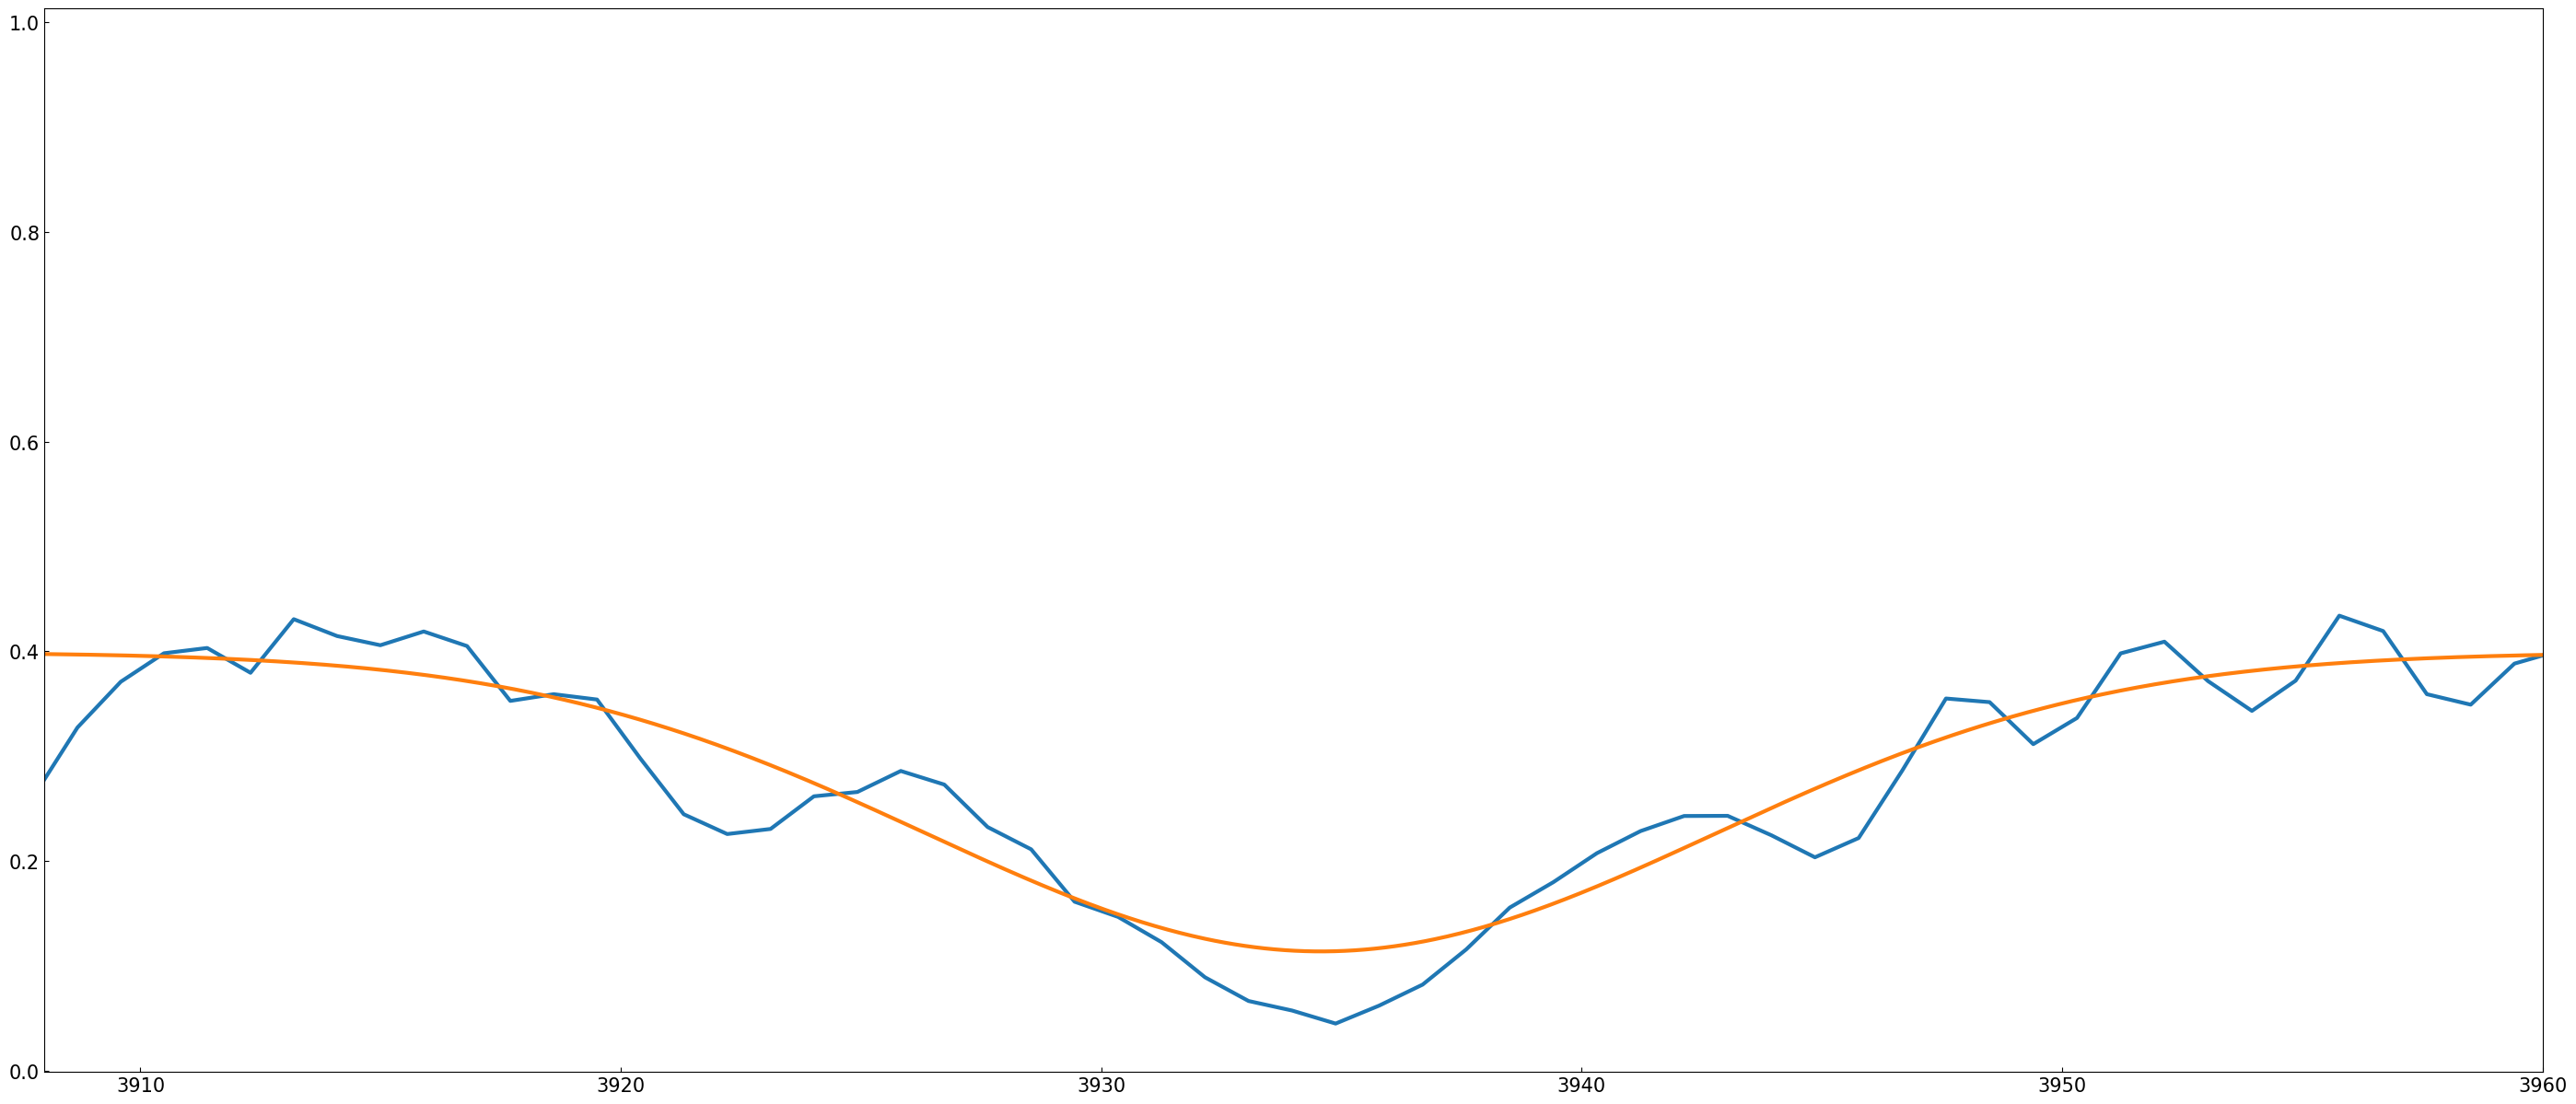

In [ ]:
self.spectra_exp = jnp.round(jnp.log10(jnp.nanmedian(self.spectra[:,1, :],axis=1))) #* 0
        #maybe add a filter here to see whats going on? 
        self.spectra = self.spectra.at[:,[1,2],:].multiply(10 ** (-1 * self.spectra_exp[:,jnp.newaxis,jnp.newaxis]))

In [ ]:
from SHEAP.fitting.functions import linear,GaussianSum,linear2,combine_auto
g_c = combine_auto([GaussianSum(n=1, constraints={}),linear2])
_, _,_,mask_fit = mask_builder(Spectra,inner_limits=inner_limits,outer_limits=outer_limits)
c_ca =sum(outer_limits)/2# where to measure the continuum
fit_region_g, masked_uncertainties_g,_,mask_fit_g = mask_builder(Spectra,outer_limits=outer_limits)
signal_noise_region = jnp.nanmedian(jnp.where(mask_fit_g,jnp.nan,Spectra[:,1,:]/Spectra[:,2,:]),axis=1)
min_value = jnp.nanmin(jnp.where(mask_fit_g, jnp.inf, Spectra[:, 1, :]),axis=1)
median_region = jnp.nanmedian(jnp.where(mask_fit,jnp.nan,Spectra[:,1,:]),axis=1)
initial_params_g = jnp.array([(min_value-median_region)*1.2,jnp.ones(min_value.shape)*c_ca,jnp.ones(min_value.shape)*4,-10.*jnp.ones(Spectra.shape[0]),median_region]).T
    #
Master_Gaussian = MasterMinimizer(g_c, non_optimize_in_axis=4,num_steps=num_steps)
params_g,_ = Master_Gaussian.vmap_optimize_model(initial_params_g,fit_region_g[:, 0, :],fit_region_g[:, 1, :],masked_uncertainties_g,constraints,*Master_Gaussian.default_args) 
line_center,sigma_jax = params_g[:,[1,2]].T
params_linear = params_g[:,-2:]
#
vmap_linear = vmap(linear2, in_axes=(0, 0), out_axes=0) 
Baselines = vmap_linear(fit_region_g[:, 0, :],params_linear)
#
flux_ew = vmap_linear(line_center,params_linear)
amplitude_star_jax = params_g[:,0] + flux_ew #params_g is negative
    #
EWfin = jnp.where(jnp.isnan(line_center),10,-1.0 * vmap_get_EQW_mask(Spectra,Baselines,mask_fit_g))

/home/felipe/work/SMBH_estimation/SHEAP_developer/SHEAP


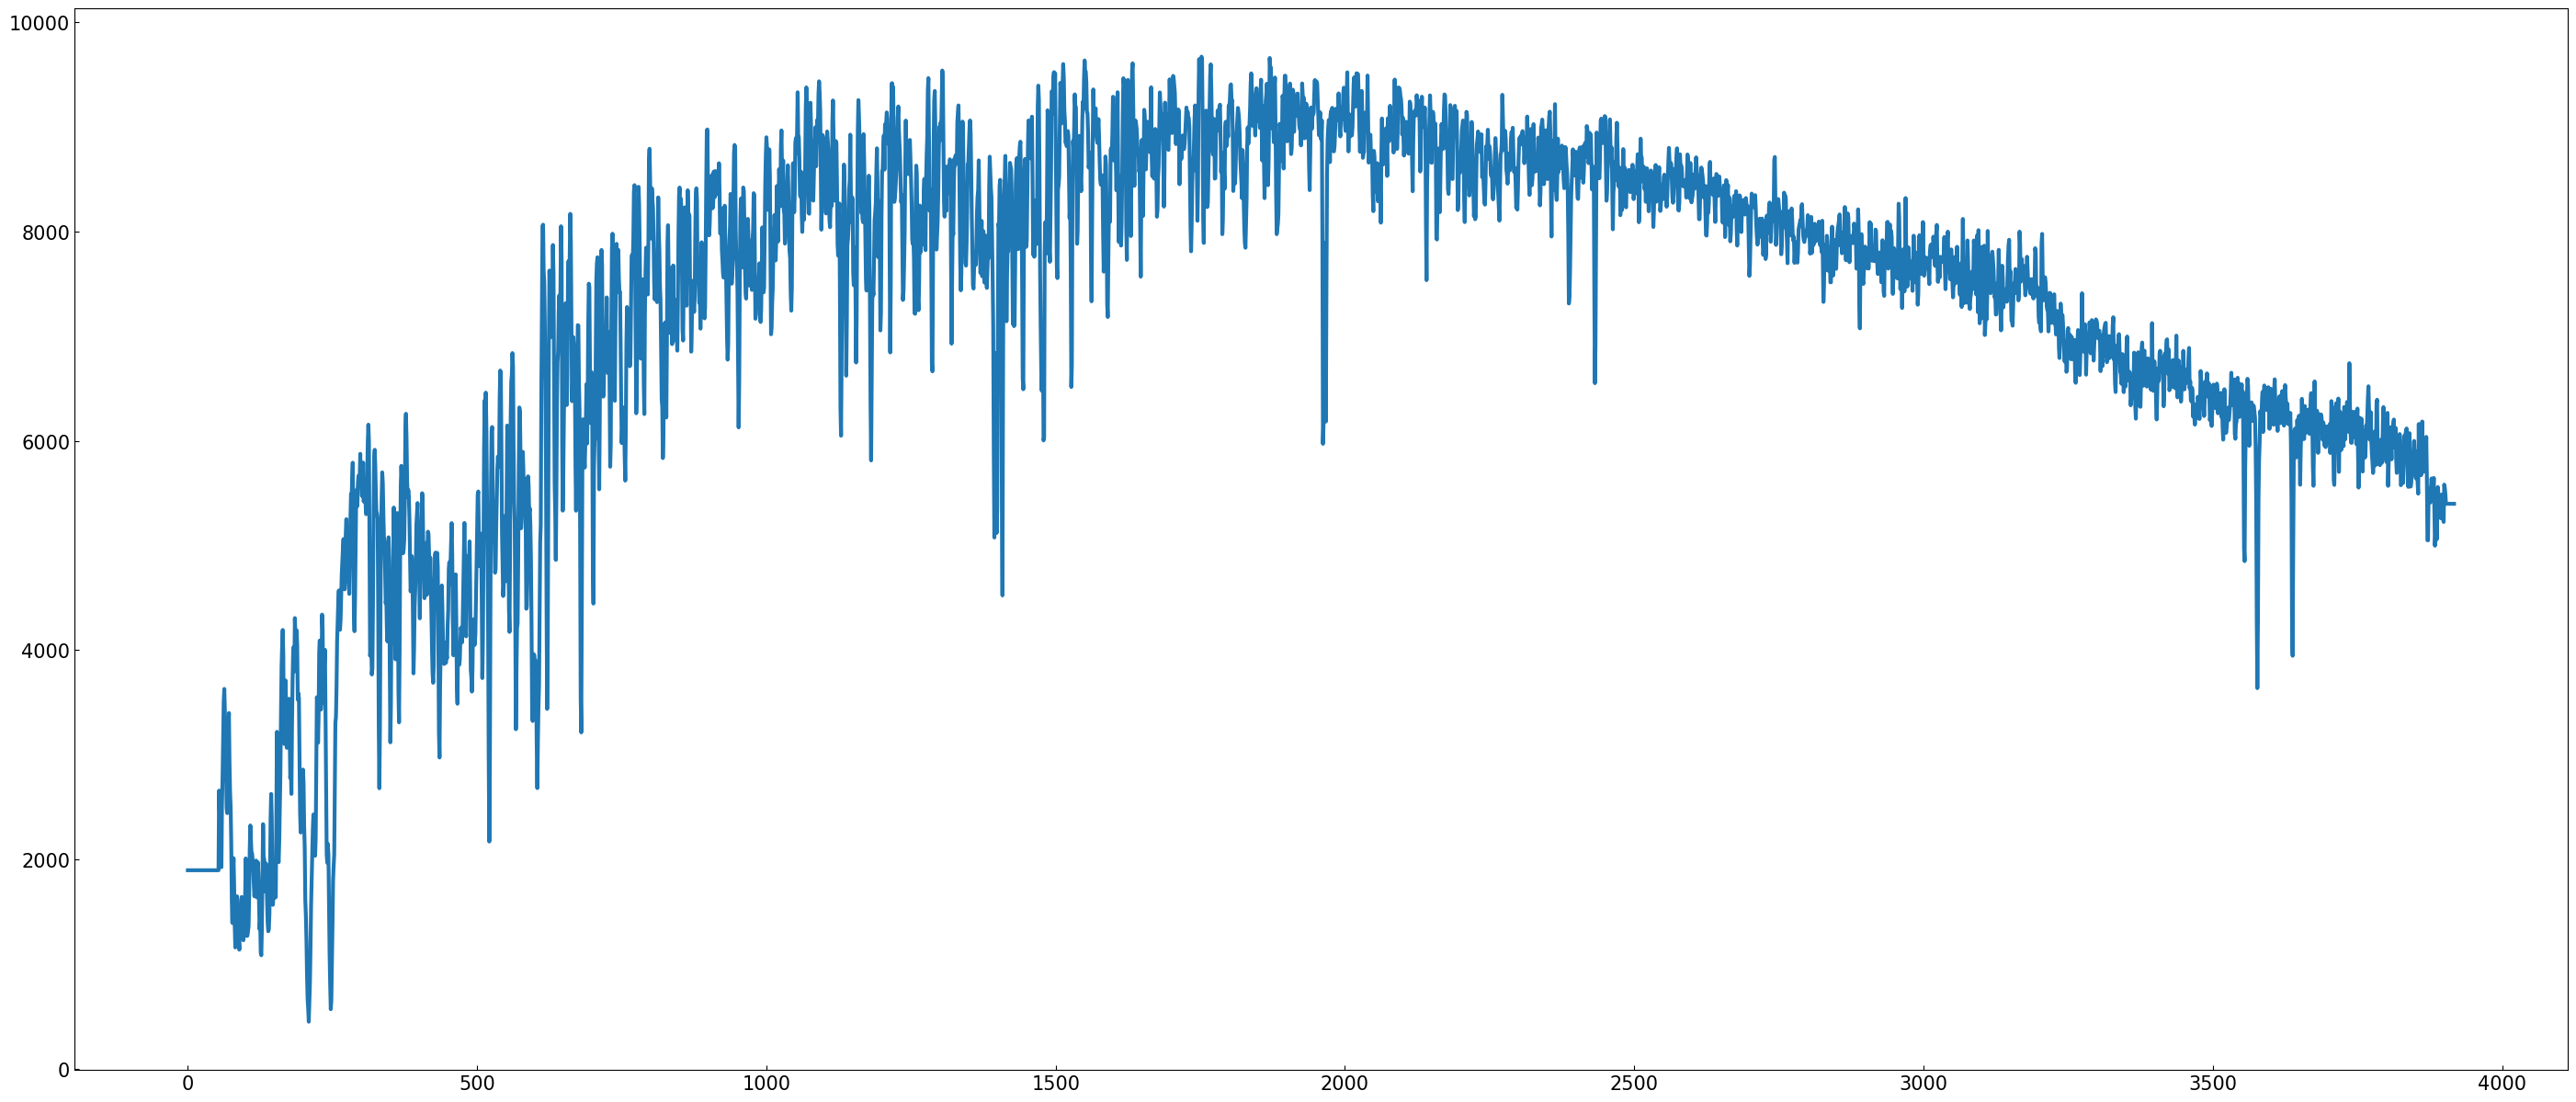

In [44]:
plt.plot(flux_kstar)

In [152]:
host_detected,fit_region_g,mask_fit,masked_uncertainties_g,outer_limits,Master_Gaussian,params_g,mask_fit_g,Baselines,AN,EWfin,vel,signal_noise_region,params_linear,initial_params_g,host_flux = Extract_host_star_new(test_clase.spectra,num_steps=1000)
dr_filtered[["EWfin","vel","signal_noise_region","AN"]] = jnp.vstack([EWfin,vel,signal_noise_region,AN]).T
dr_filtered["host_detected"] = [i in host_detected for i in range(len(dr_filtered))]
matched_df = dr_filtered.merge(
    Objects_low_stellar_mass_with_stellar_contribution_all, 
    on=["PLATE", "MJD", "FIBERID","Z"], 
    how="inner")
matched_df[["stars_Cont_5100","stars_Cont_6200"]] = matched_df[["stars_Cont_5100_y","stars_Cont_6200_y"]]

/home/felipe/work/SMBH_estimation/SHEAP_developer/SHEAP


In [153]:
y = test_clase.spectra[:,1,:] - host_flux

In [161]:
jnp.sum(y<0,axis=1)

Array([   7,    0,    0,    0,    0,    0,   33,    0,    0,    0,    3,
          0,    0,    1,    0,    2,    1,    6,    0,    0,    0,    0,
          7,    0,    2,    0,    1,    0,    3,    0,    0,    0,    0,
          0,    0,    3,    0,   12,    2,    0,    0,   12,    1,    0,
          0,    1,    0,    2,    0,    0,    3,   16,    0,    8,    4,
         38,    0,   16,    3,    1,   15,    2,    0,    1,    1,    1,
          0,    3,   68,    2,    3,    1,    0,   23,    0,    2,   16,
         85,    0,    1,    0,    0,    2,    0,    4,    0,   30,    1,
          0,    0,    0,  115,    3,    0,    0,    1,    0,    6,    0,
          0,    0,    0,    1,    0,    1,    5, 1789,   15,    5,    1,
          0,    2,    5,    0,   13,    0,    0,    1,    1,    3,    5,
          2,    0,    9,    4,    0,    0,    0,    0,    6,    1,    0,
         75,    1,    1,   18,    0,  625,    0,    0,    1,    0,  335,
          0,   29,    1,    1,    1,    0,   59,   

In [174]:
np.where(jnp.sum(y<0,axis=1)==1783)

(array([333]),)

In [172]:
col_plot = ["EWfin","rAGN_Cont_5100","vel","signal_noise_region","rAGN_stars_5100","stars_Cont_5100","AN","agn_slope","host_detected"]
#
Sheap_plots= Sheap_ploting(test_clase,fit_region_g,mask_fit,mask_fit_g,masked_uncertainties_g,Master_Gaussian,params_g,Baselines,outer_limits,AN,EWfin,signal_noise_region,host_detected,host_flux)

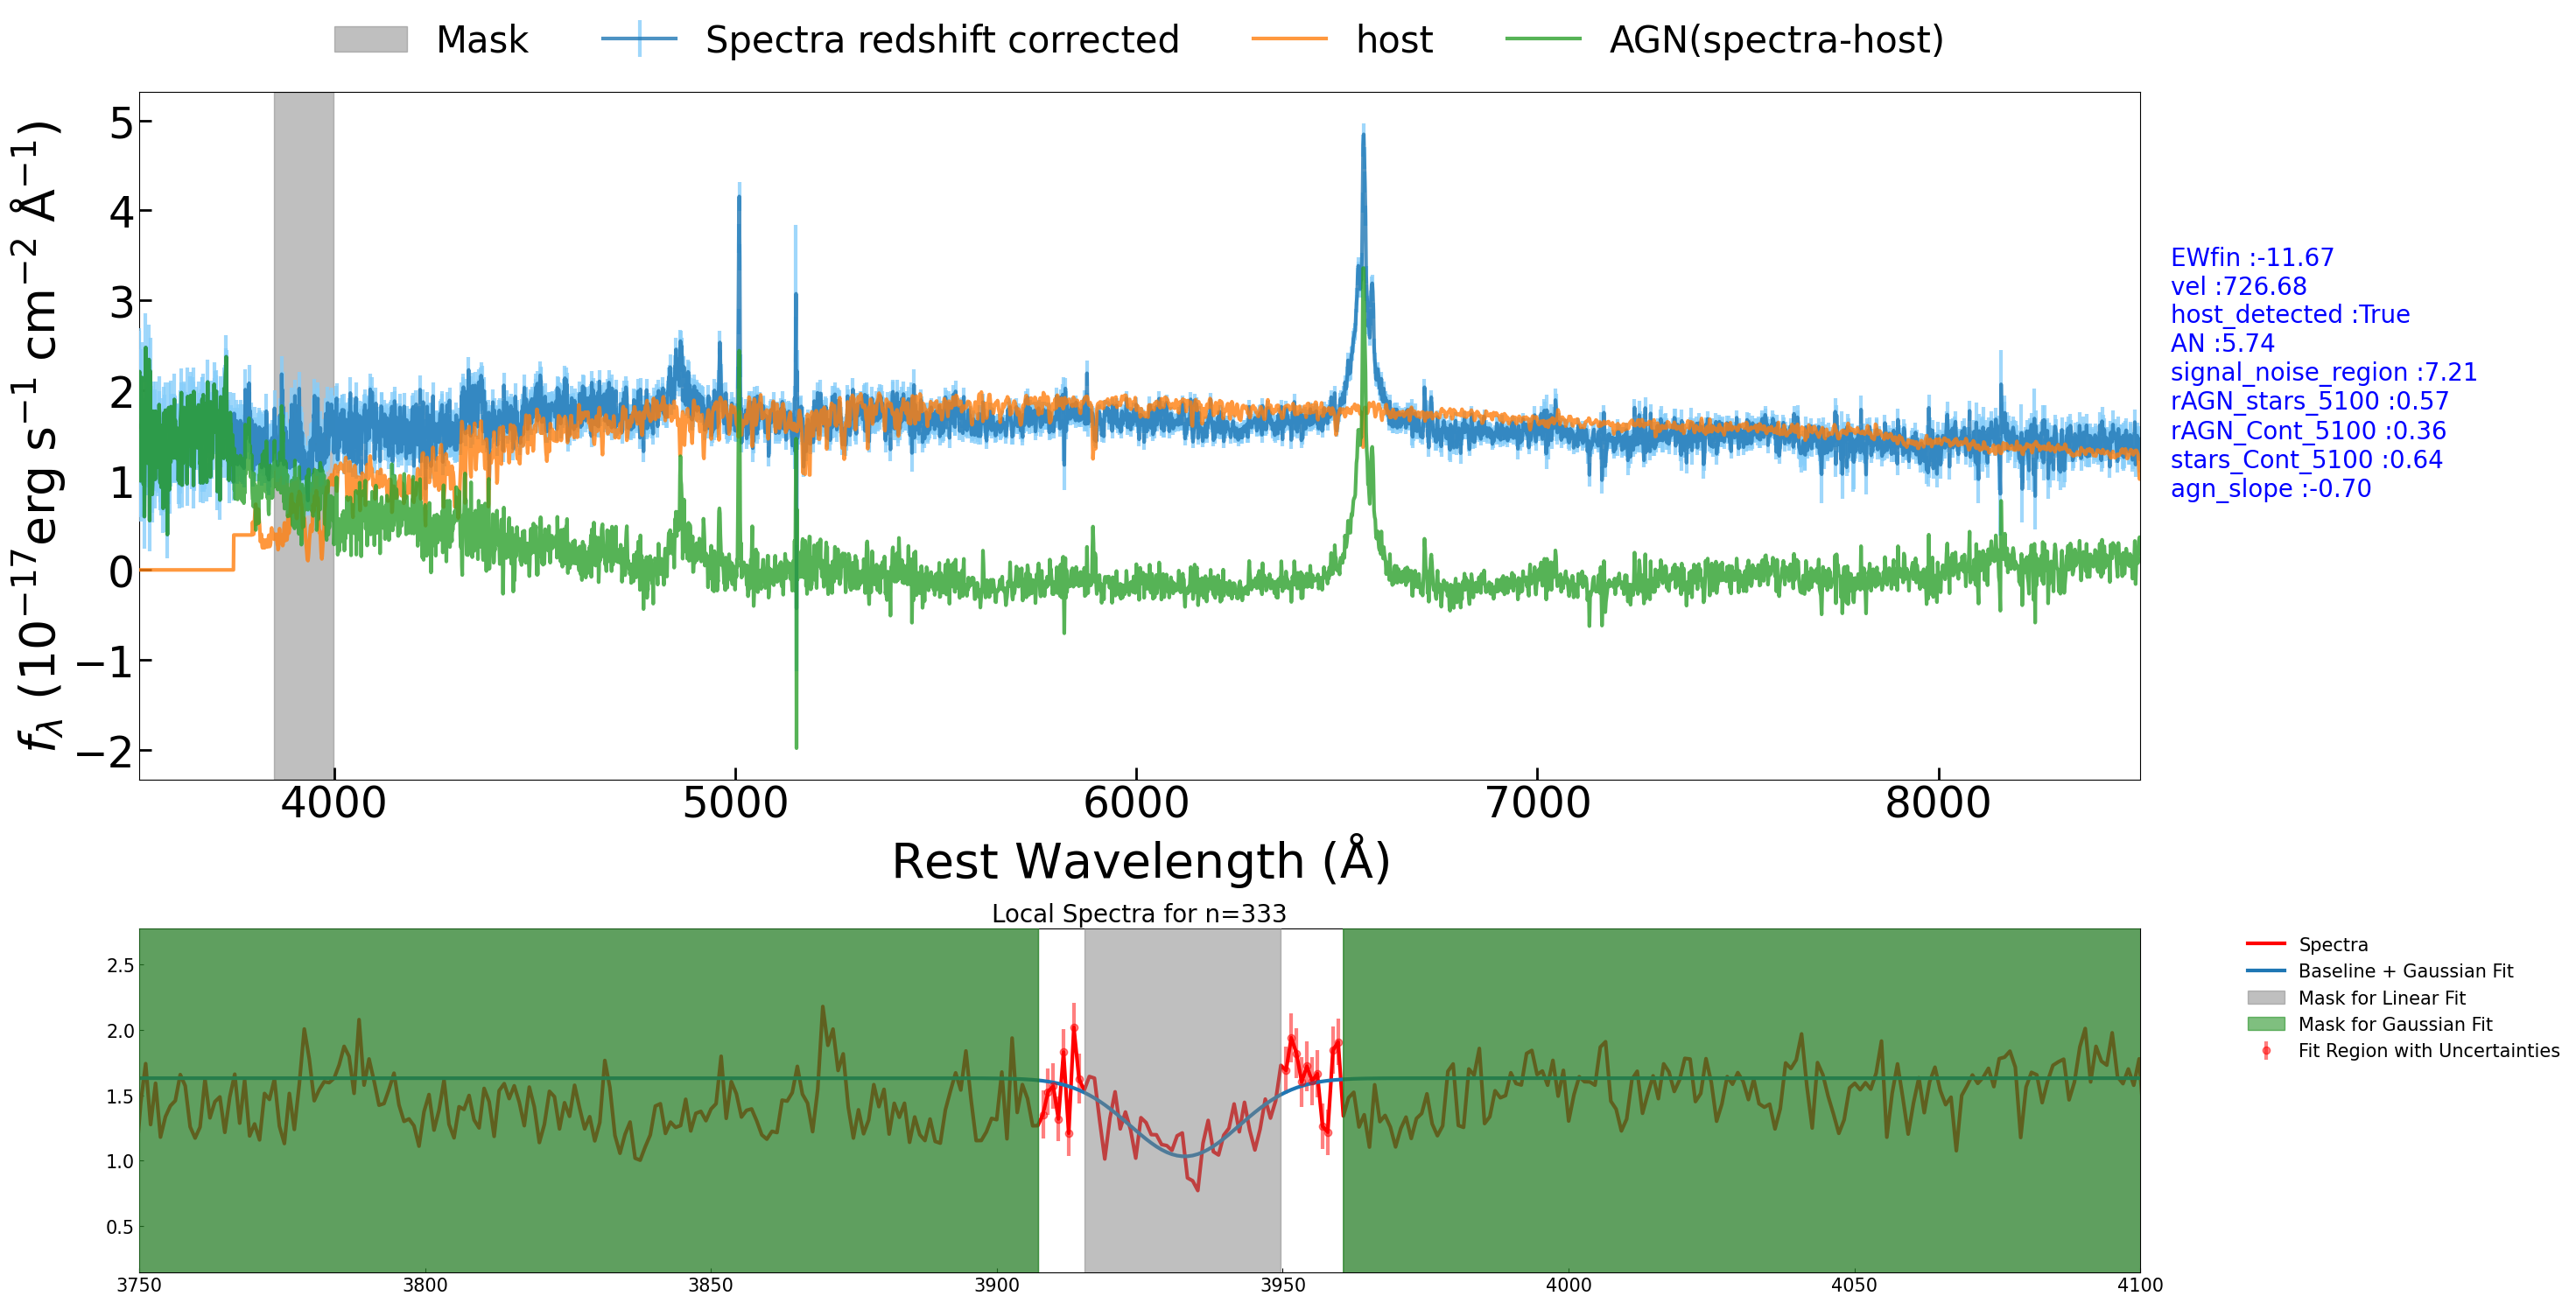

In [175]:
Sheap_plots.plot_combined(333,mask =[3850,4e3],xlim_local=[3750,4100],pandas=matched_df,add_baseline=False,add_all=True)

In [16]:
corner_plot_sns(matched_df,col_plot,"host_detected",save="corner_host_detected")

In [17]:
corner_plot_sns(matched_df,["EWfin","vel","signal_noise_region","AN","agn_slope","host_detected"],"host_detected",save="corner_agn_slope")

In [18]:
corner_plot_sns(matched_df,["EWfin","AN","agn_slope","host_detected"],"host_detected",save="corner_agn_slopev2")

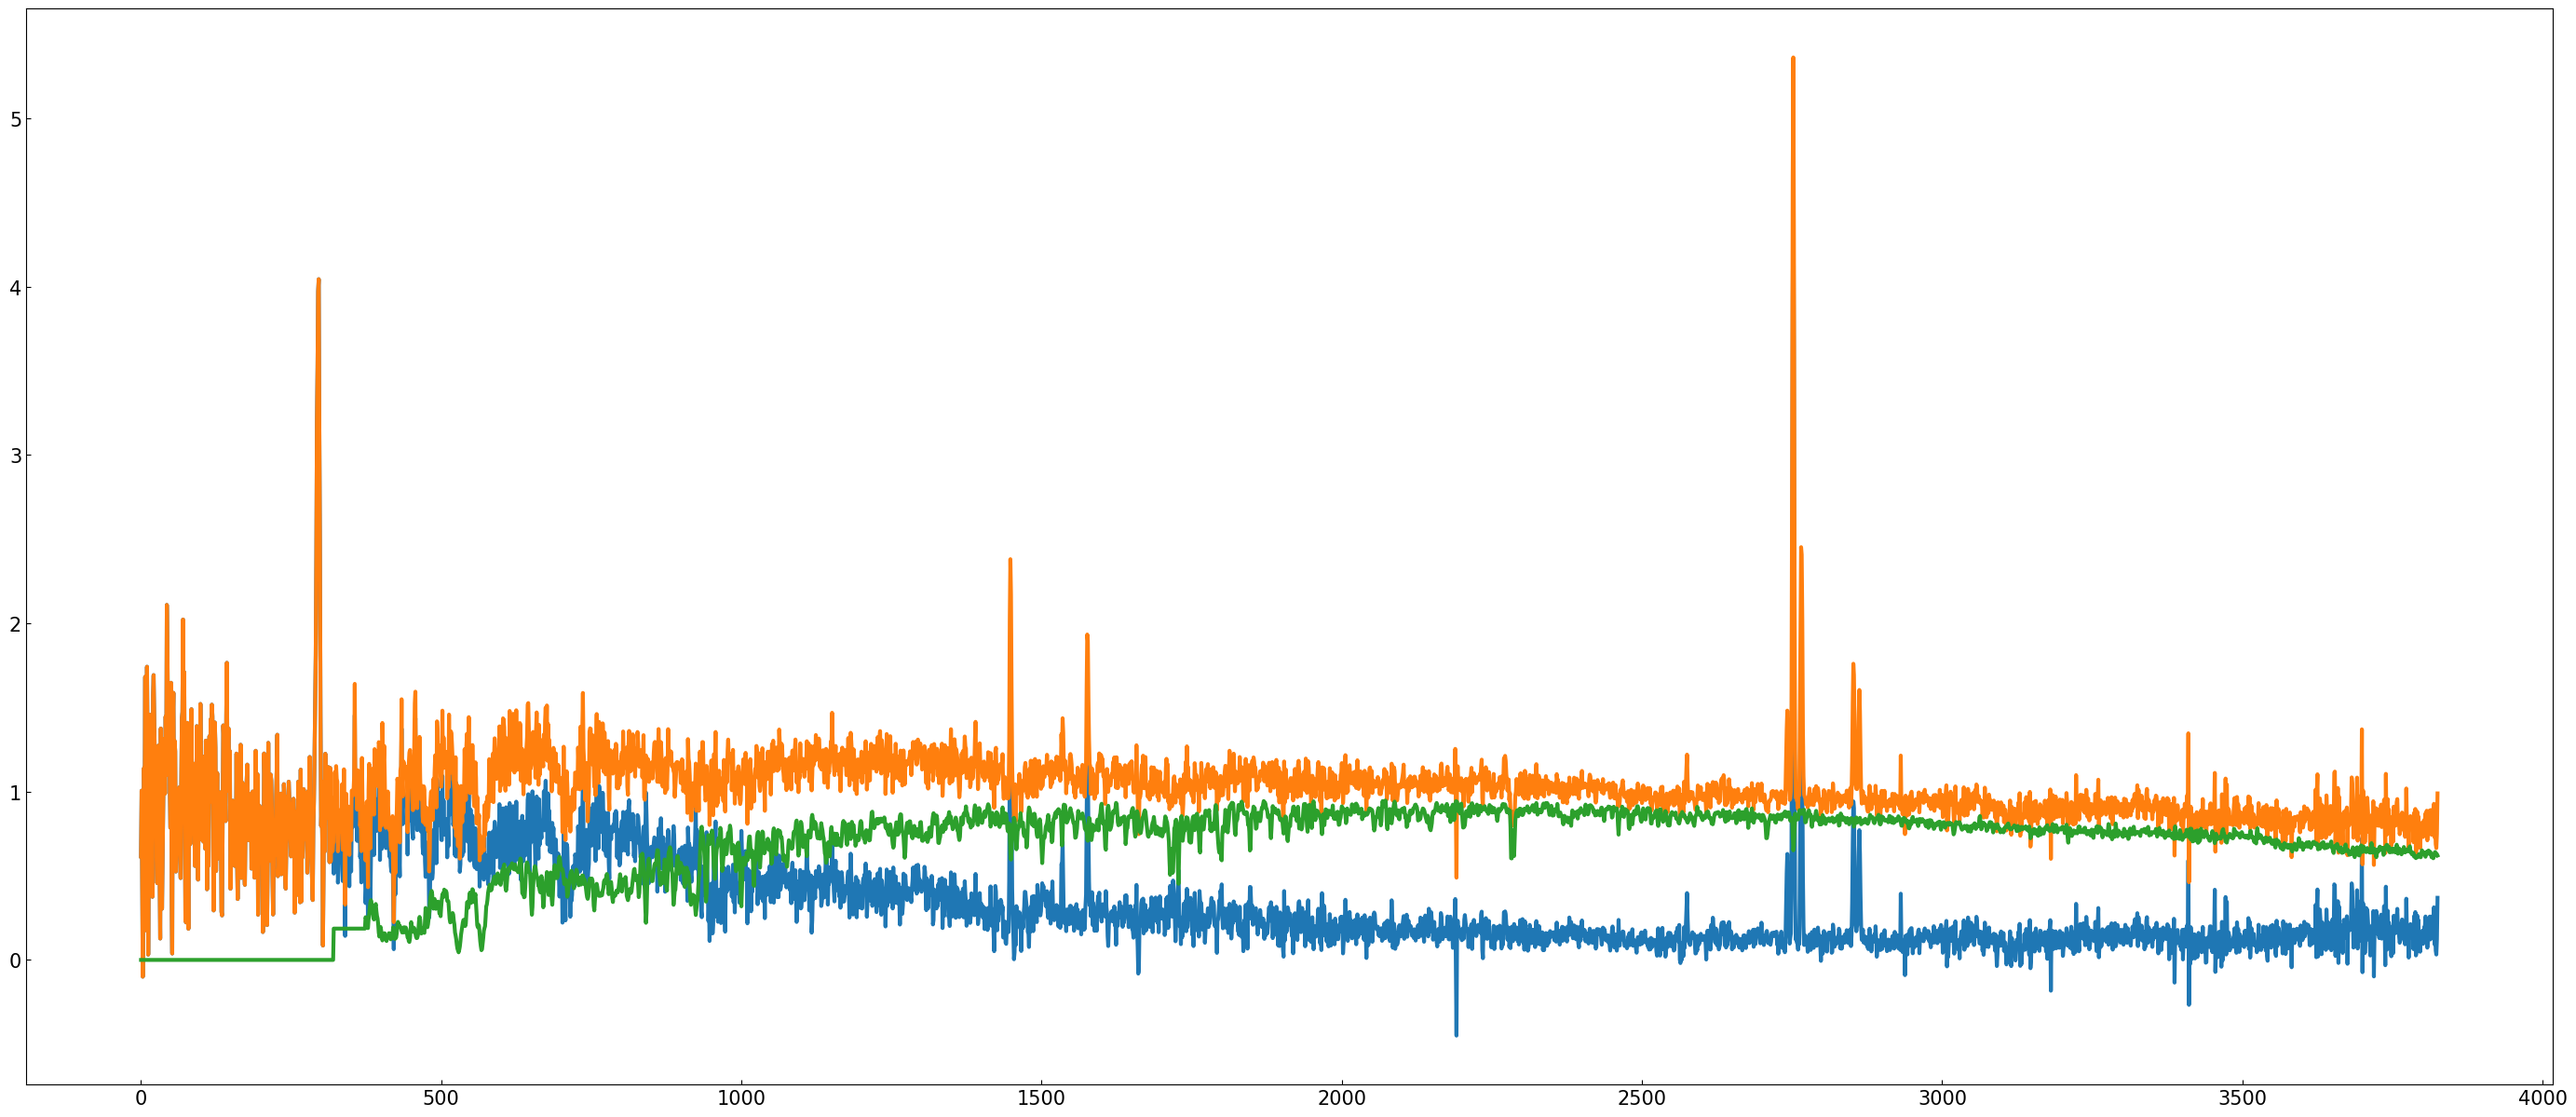

In [12]:
plt.plot(test_clase.spectra[10, 1, :]  - host_flux[10])
plt.plot(test_clase.spectra[10, 1, :] )
plt.plot(host_flux[10])

In [14]:
c = 0
rng = np.random.default_rng(12345)
rints = rng.integers(low=0, high=len(dr_filtered), size=len(dr_filtered))
for i in range(len(matched_df)):
    #if i not in host_detected:
    if os.path.isfile(f"images/{i}.jpg"):
      continue
      #aqui habria q agregar un "y si hay host what"
    Sheap_plots.plot_combined(i,mask =[3850,4e3],xlim_local=[3750,4100],pandas=matched_df,add_baseline=False,add_all=True,save=f"{i}")#,save=f"{i}")#,save="new_problem")#)#,mask=[3910,3950]) new_problem= 7077
    #break
    #c += 1
    #break
    #plot_sheapspectra(i,mask=[3900,3980])#,xlim=[3000,4500],mask=[3910,3950])
    #break

In [88]:
def plot_local(n,save='',**kwargs):
    fig, ax = plt.subplots(figsize=(20, 6))

    # Plot the spectra
    ax.plot(test_clase.spectra[n, 0, :],test_clase.spectra[n, 1, :],color='red',label='Spectra')

    # Add error bars
    ax.errorbar(fit_region_g[n][0][~mask_fit[n]],fit_region_g[n][1][~mask_fit[n]],yerr=masked_uncertainties_g[n][~mask_fit[n]],fmt='o',color='red',alpha=0.5,label='Fit Region with Uncertainties')

    # Plot the baseline plus Gaussian fit
    baseline_plus_gaussian = Master_Gaussian.func(test_clase.spectra[n, 0, :],params_g[n]) + Baselines[n]
    ax.plot(test_clase.spectra[n, 0, :],baseline_plus_gaussian,label='Baseline + Gaussian Fit')

    # Calculate the median of the fit region's y-values (excluding masked data)
    median = jnp.median(fit_region_g[n][1][~mask_fit[n]])

    # Fill between for the linear fit mask
    ax.fill_between(test_clase.spectra[n, 0, :],0,jnp.nanmax(test_clase.spectra[n, 1, :]),where=mask_fit[n],color='grey',alpha=0.5,label='Mask for Linear Fit',zorder=10)

    # Fill between for the Gaussian fit mask
    ax.fill_between(test_clase.spectra[n, 0, :],0,jnp.nanmax(test_clase.spectra[n, 1, :]),where=mask_fit_g[n],color='green',alpha=0.5,label='Mask for Gaussian Fit',zorder=10)

    # Set the x and y limits
    ax.set_xlim(outer_limits)
    if "xlim" in kwargs.keys():
        ax.set_xlim(*kwargs["xlim"])
    ax.set_ylim([median*0.2, median*1.7])
    if "ylim" in kwargs.keys():
        ax.set_ylim(*kwargs["ylim"])
    # Add dynamic text based on axis limits
    # (We'll handle positioning differently below)
    # Define your variables for text
    AN_val = AN[n]
    EWfin_val = EWfin[n]
    vel_val = vel[n]
    signal_noise_val = signal_noise_region[n]
    is_in_index = n in index

    # Create a multi-line string with one variable per line
    text_string = (f"AN: {AN_val:.2f}\n"f"EWfin: {EWfin_val:.2f}\n"f"vel: {vel_val:.2f}\n"f"Signal noise region: {signal_noise_val:.2f}\n"f"is in index?: {is_in_index}")

    # Add the multi-line text below the legend using fig.text
    # Positioning:
    # - x: 0.9 (adjust as needed to align with the legend)
    # - y: 0.1 (10% from the bottom)
    # Adjust y-coordinate as needed (0 is bottom, 1 is top)
    fig.text(0.65, 0.4,  text_string,fontsize=15,color='blue',verticalalignment='center',horizontalalignment='left',bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    # Add title
    ax.set_title(f"Spectra Plot for n={n}", fontsize=16)

    # Position the legend outside the plot
    ax.legend(loc='upper left',bbox_to_anchor=(1.05, 1),borderaxespad=0.0,fontsize=15)

    # Adjust the layout to make room for the legend and the text
    # Increase the right margin to accommodate the legend
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    # Optionally save the figure
    if save:
        plt.savefig(f"images/{save}.jpg", dpi=300, bbox_inches='tight')

    # Display the plot
    plt.show()

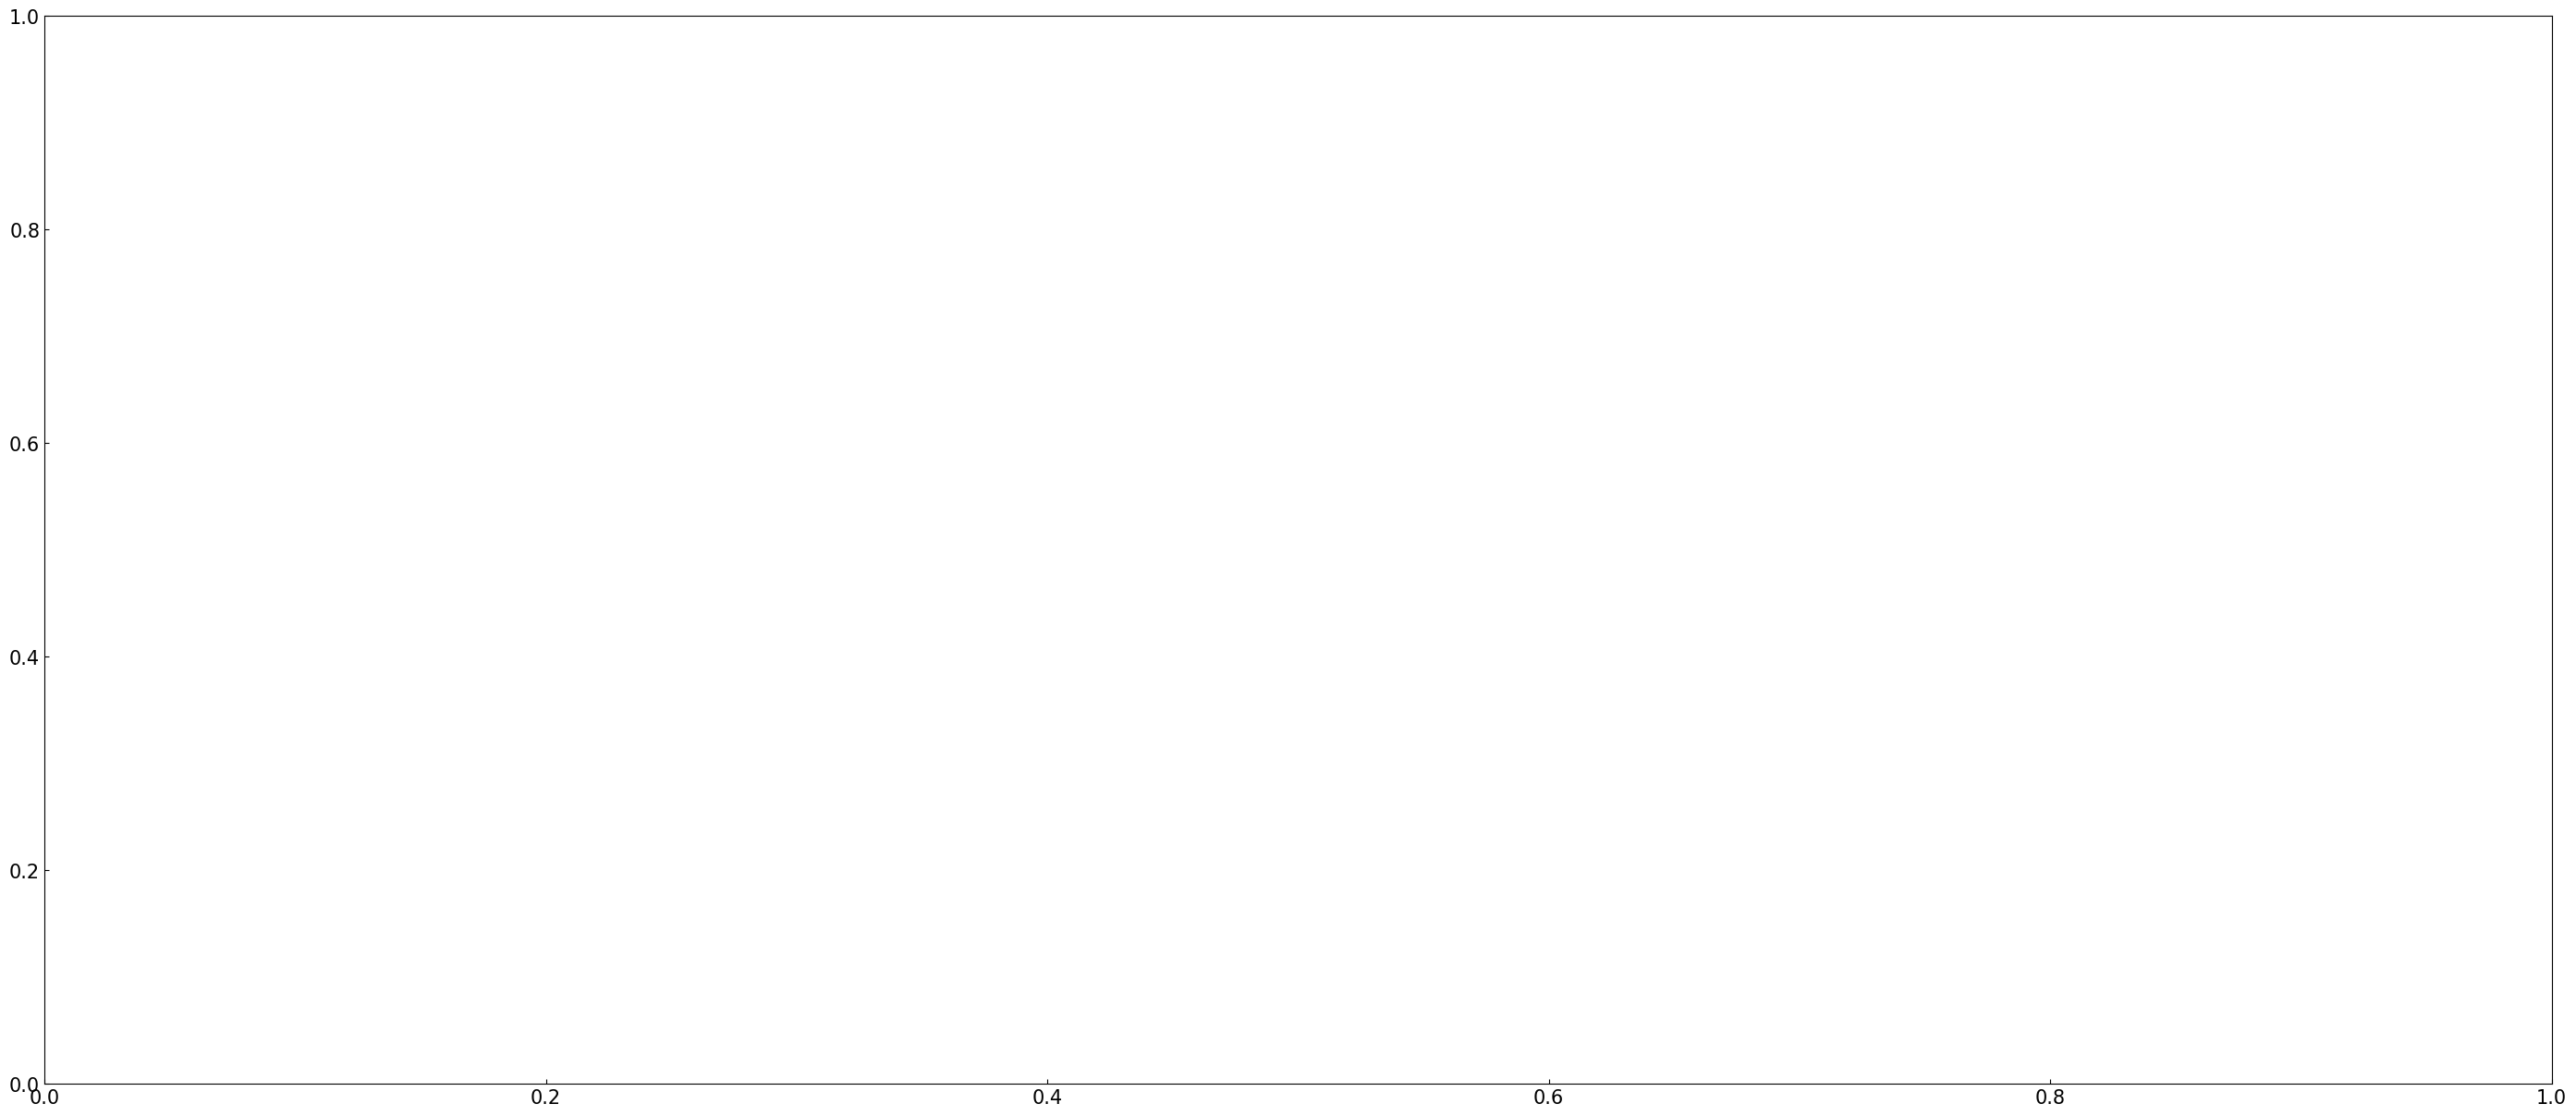

In [89]:
fig, ax1 = plt.subplots(1, 1, figsize=(35, 15))

(np.float64(0.0), np.float64(1.0))

In [59]:
def plot_sheapspectra(n,save='',**kwargs):
    import numpy as np 
    fig, ax1 = plt.subplots(1, 1, figsize=(35, 15))
    ax1.tick_params(which="both", bottom=True, top=True, left=True, right=True,
                length=10, width=2, labelsize=35)  # Increase tick length and width
    ax1.xaxis.label.set_size(40)  # Set x-axis label font size
    ax1.yaxis.label.set_size(40)  # Set y-axis label font size
    x_axis = test_clase.spectra[:,0][n] #it is supouse to be resframed already
    ax1.errorbar(x_axis,test_clase.spectra[n,1,:],yerr=test_clase.input_spectra[n,2,:], \
            color='b', ecolor='lightskyblue', label='Spectra redshift corrected', zorder=1)
    ax1.set_ylabel(r'$ f_{\lambda}$ ($\rm 10^{-17} {\rm erg\;s^{-1}\;cm^{-2}\;\AA^{-1}}$)')
    ax1.set_xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)')
    ax1.set_xlim(jnp.nanmin(x_axis),jnp.nanmax(x_axis))
    if "ylim" in kwargs.keys():
        ax1.set_ylim(*kwargs["ylim"])
    ylimit = ax1.get_ylim()
    if "xlim" in kwargs.keys():
        ax1.set_xlim(*kwargs["xlim"])
    if "mask" in  kwargs.keys():
        mask = kwargs["mask"]
        if isinstance(mask,list):
            mask_x = np.ones_like(x_axis).astype(bool)
            mask_x[x_axis<min(mask)] = False
            mask_x[x_axis>max(mask)] = False
        ax1.fill_between(x_axis,*ylimit,where=mask_x,color='grey',alpha=0.5,label='Mask',zorder=10)
    ax1.legend(
    loc='lower center', 
    bbox_to_anchor=(0.5, 1),  # Adjust the 1.25 as needed to move legend up/down
    fancybox=True, 
    shadow=False, 
    ncol=4  # Number of columns in legend
    ,fontsize=30)
    ax1.set_ylim(*ylimit)
    plt.tight_layout()  # Helps ensure everything fits nicely
    if save:
        plt.savefig(f"images/{save}.jpg", dpi=300, bbox_inches='tight')

In [ ]:
n = 1047
fig, ax1 = plt.subplots(1, 1, figsize=(35, 15))
ax1.tick_params(which="both", bottom=True, top=True, left=True, right=True,
                length=10, width=2, labelsize=35)  # Increase tick length and width
ax1.xaxis.label.set_size(40)  # Set x-axis label font size
ax1.yaxis.label.set_size(40)  # Set y-axis label font size

x_axis = test_clase.input_spectra[n,0,:]/(1+test_clase.z[n])
ax1.errorbar(x_axis,test_clase.input_spectra[n,1,:],yerr=test_clase.input_spectra[n,2,:], \
            color='b', ecolor='lightskyblue', label='Spectra redshift corrected', zorder=1)
ax1.errorbar(x_axis,test_clase.spectra[n,1,:],yerr=test_clase.input_spectra[n,2,:]*(1+test_clase.z[n]), \
            color='g', ecolor='yellowgreen', label='Spectra redshift and redening corrected', zorder=1)
ax1.set_ylabel(r'$ f_{\lambda}$ ($\rm 10^{-17} {\rm erg\;s^{-1}\;cm^{-2}\;\AA^{-1}}$)')
ax1.set_xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)')
# Place the legend outside, at the top center of the figure
ax1.legend(
    loc='lower center', 
    bbox_to_anchor=(0.5, 1),  # Adjust the 1.25 as needed to move legend up/down
    fancybox=True, 
    shadow=False, 
    ncol=4  # Number of columns in legend
,fontsize=30)
ax1.set_xlim(jnp.nanmin(x_axis),jnp.nanmax(x_axis))
#ax1.set_xlim(6.55e3,6.6e3)
#ax1.set_ylim(60,140)
plt.tight_layout()  # Helps ensure everything fits nicely
plt.savefig("test.png")

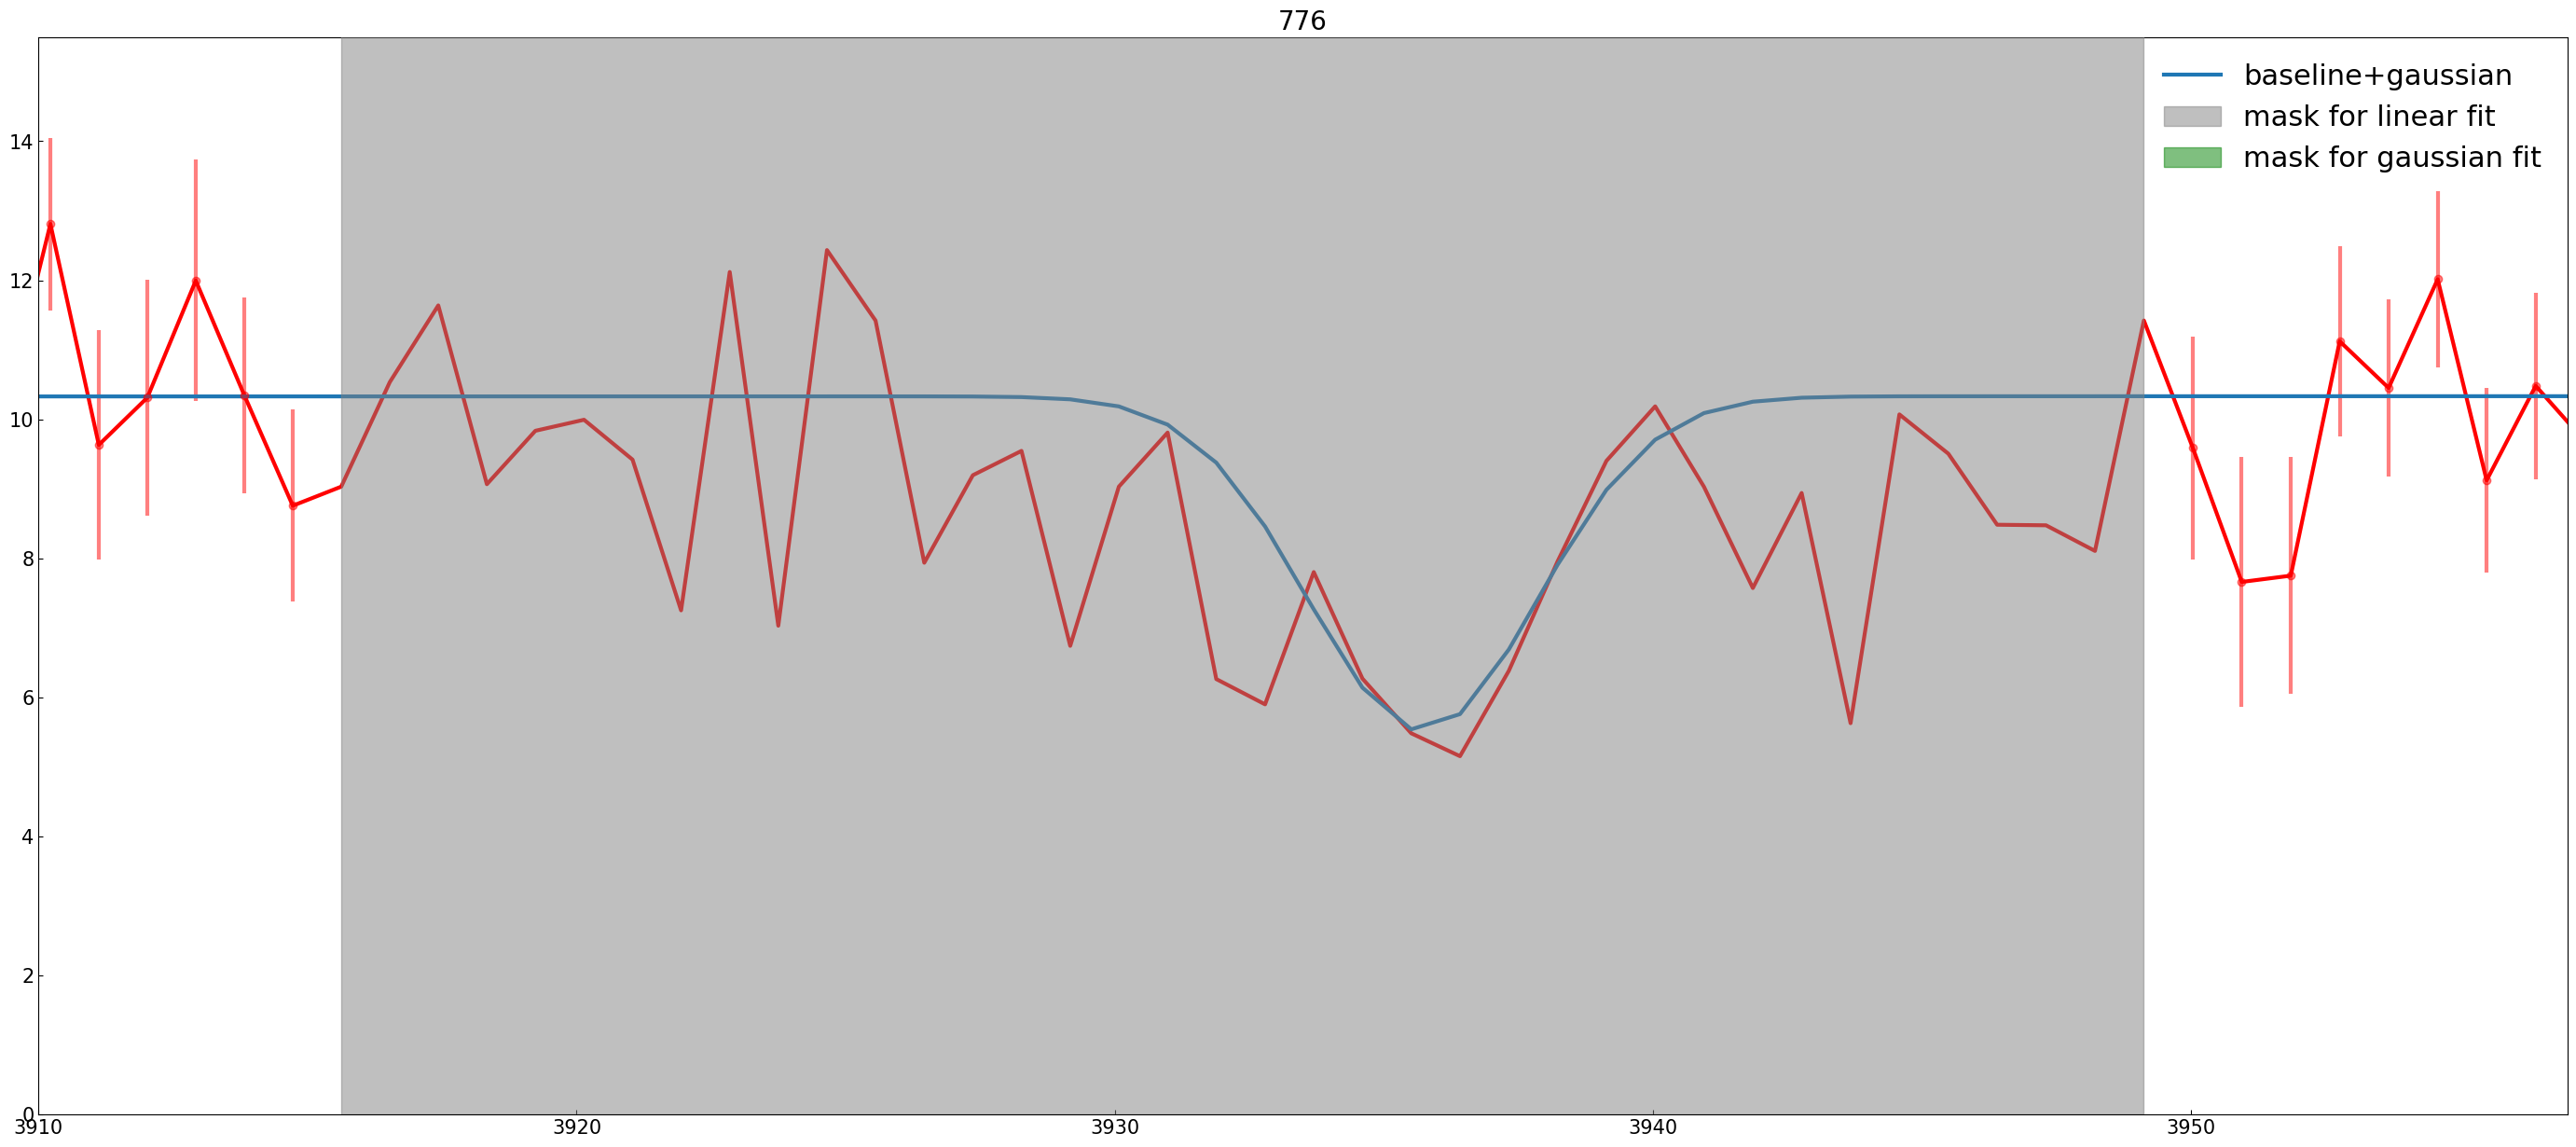

In [ ]:

plt.plot(test_clase.spectra[n,0, :],test_clase.spectra[n,1, :],c='r')
plt.errorbar(fit_region_g[n][0][~mask_fit[n]], fit_region_g[n][1][~mask_fit[n]], yerr=masked_uncertainties_g[n][~mask_fit[n]], fmt='o',color="r",alpha=0.5)
plt.plot(test_clase.spectra[n,0, :],Master_Gaussian.func(test_clase.spectra[n,0, :],params_g[n])+Baselines[n],label="baseline+gaussian")
median = jnp.median(fit_region_g[n][1][~mask_fit[n]])
plt.fill_between(test_clase.spectra[n, 0, :], 0, jnp.nanmax(test_clase.spectra[n,1, :]), where=mask_fit[n], color="grey", alpha=0.5, zorder=10,label="mask for linear fit")
plt.fill_between(test_clase.spectra[n, 0, :], 0, jnp.nanmax(test_clase.spectra[n,1, :]), where=mask_fit_g[n], color="green", alpha=0.5, zorder=10,label="mask for gaussian fit")
plt.xlim(outer_limits)
plt.ylim([median*0.,median*1.5])
plt.text()
plt.title(n)
plt.legend(loc='best')
#plt.savefig(f"images/{n}.jpg")
plt.show()
#plt.close()

In [9]:
#index,fit_region_g,mask_fit,masked_uncertainties_g,outer_limits,Master_Gaussian,params_g,mask_fit_g,Baselines = Extract_host_star(test_clase.spectra)

In [21]:

for n in index:
    plt.plot(test_clase.spectra[n,0, :],test_clase.spectra[n,1, :],c='r')
    plt.errorbar(fit_region_g[n][0][~mask_fit[n]], fit_region_g[n][1][~mask_fit[n]], yerr=masked_uncertainties_g[n][~mask_fit[n]], fmt='o',color="r",alpha=0.5)
    plt.plot(test_clase.spectra[n,0, :],Master_Gaussian.func(test_clase.spectra[n,0, :],params_g[n])+Baselines[n],label="baseline+gaussian")
    median = jnp.median(fit_region_g[n][1][~mask_fit[n]])
    plt.fill_between(test_clase.spectra[n, 0, :], 0, jnp.nanmax(test_clase.spectra[n,1, :]), where=mask_fit[n], color="grey", alpha=0.5, zorder=10,label="mask for linear fit")
    plt.fill_between(test_clase.spectra[n, 0, :], 0, jnp.nanmax(test_clase.spectra[n,1, :]), where=mask_fit_g[n], color="green", alpha=0.5, zorder=10,label="mask for gaussian fit")
    plt.xlim(outer_limits)
    plt.ylim([median*0.,median*1.5])
    plt.title(n)
    plt.legend(loc='best')
    plt.savefig(f"images/{n}.jpg")
    plt.close()

In [13]:
eigenvectors,params_linear,loss_curves_linear,masked_uncertainties,fit_array = Extract_host_pca(test_clase.spectra)

In [12]:
from SHEAP.fitting.functions import linear_combination

In [23]:
eigenvectors

Array([[[ 0.006176  ,  0.006176  ,  0.006176  , ...,         nan,
                 nan,         nan],
        [-0.014234  , -0.014234  , -0.014234  , ...,         nan,
                 nan,         nan],
        [ 0.018544  ,  0.018544  ,  0.018544  , ...,         nan,
                 nan,         nan],
        ...,
        [-0.00873842, -0.00873827, -0.00918166, ...,         nan,
                 nan,         nan],
        [ 0.002937  ,  0.00263955,  0.00290491, ...,         nan,
                 nan,         nan],
        [-0.03243092, -0.03265414, -0.03284602, ...,         nan,
                 nan,         nan]],

       [[ 0.006176  ,  0.006176  ,  0.006176  , ...,         nan,
                 nan,         nan],
        [-0.014234  , -0.014234  , -0.014234  , ...,         nan,
                 nan,         nan],
        [ 0.018544  ,  0.018544  ,  0.018544  , ...,         nan,
                 nan,         nan],
        ...,
        [-0.01628162, -0.01621744, -0.01614913, ...,  

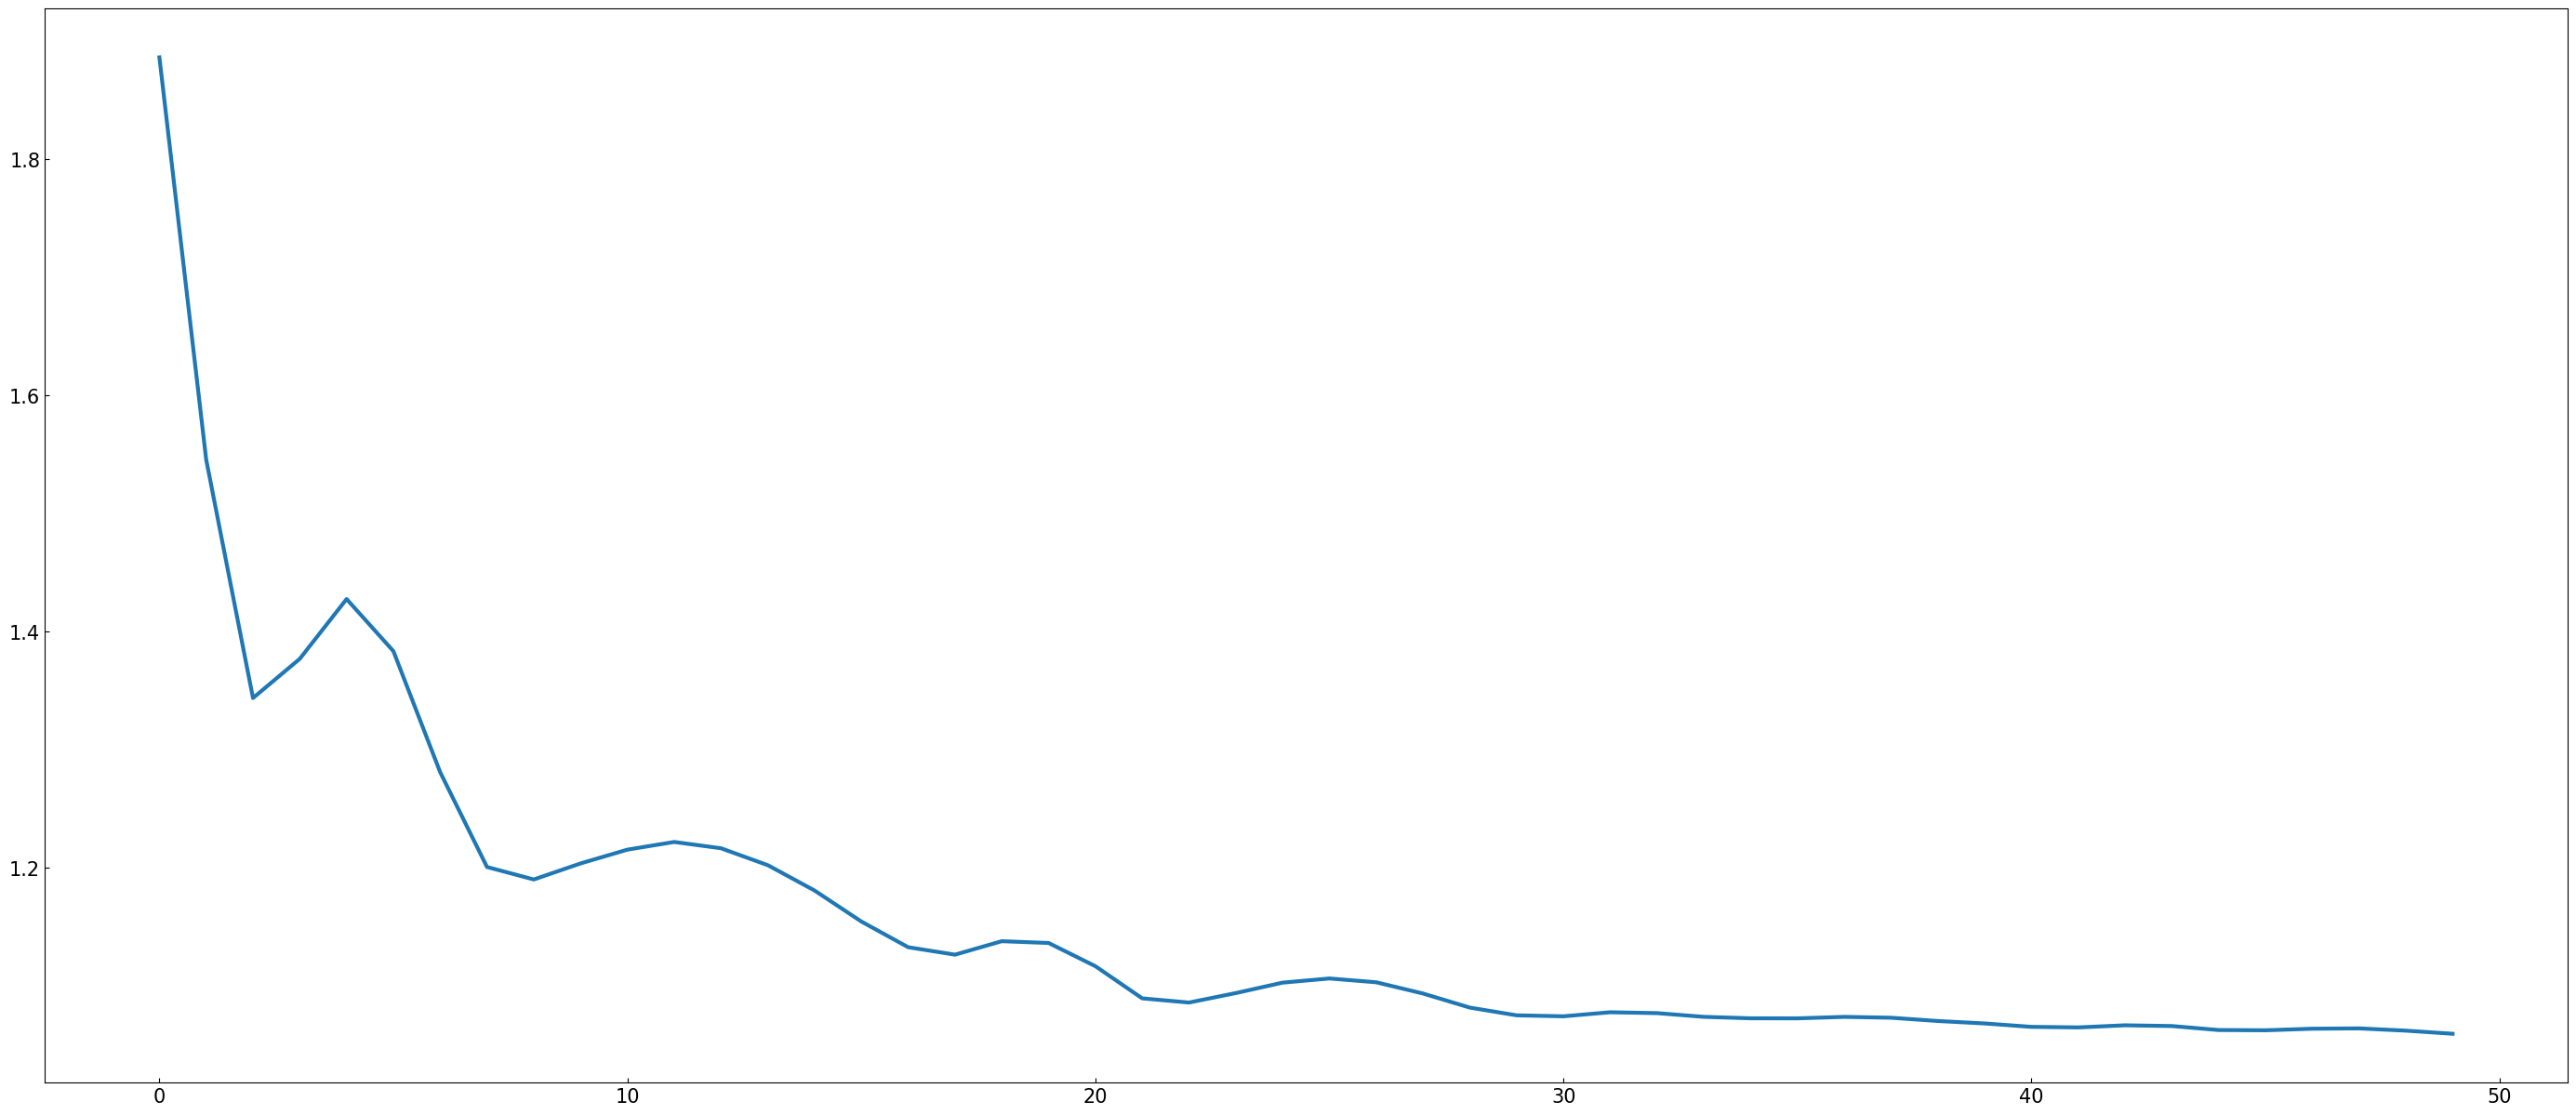

In [38]:
n = 300
plt.plot(jnp.array(loss_curves_linear).T[n])
plt.show()
plt.plot(linear_combination(eigenvectors[n],params_linear[n]),label="pca")
plt.plot(jnp.nansum(eigenvectors[n][10:].T*100*params_linear[n][10:],axis=1),label="pca_qso")
    #linear_combination(A[n],params_linear[n]),label="pca_galaxy")
plt.plot(jnp.nansum(eigenvectors[n][:10].T*100*params_linear[n][:10],axis=1),label="pca_galaxy")
plt.plot(fit_array[:, 1, :][n],alpha=0.5,label="obj")
plt.fill_between(jnp.arange(len(test_clase.spectra[n, 0, :])), -5, jnp.nanmax(test_clase.spectra[n,1, :]), where=masked_uncertainties[n]!=1e11, color="grey", alpha=0.1, zorder=10,label="mask for linear fit")
#plt.plot(masked_uncertainties[n],alpha=0.5,label="e")
plt.ylim(-5,50)
plt.xlim(0,jnp.nanargmax(fit_array[:, 0, :][n]))
plt.legend()
plt.tight_layout()
plt.savefig(f"images/{n}_pca.jpg")
plt.close()

In [18]:
jnp.nanargmax(fit_array[:, 0, :][n])

Array(4614, dtype=int64)

In [59]:
params_g,_ = Master_Gaussian.vmap_optimize_model(initial_params_g,fit_region_g[:, 0, :],fit_region_g[:, 1, :] - Baselines,masked_uncertainties_g,*Master_Gaussian.default_args) 

ValueError: Expected 3 parameters, got 999.

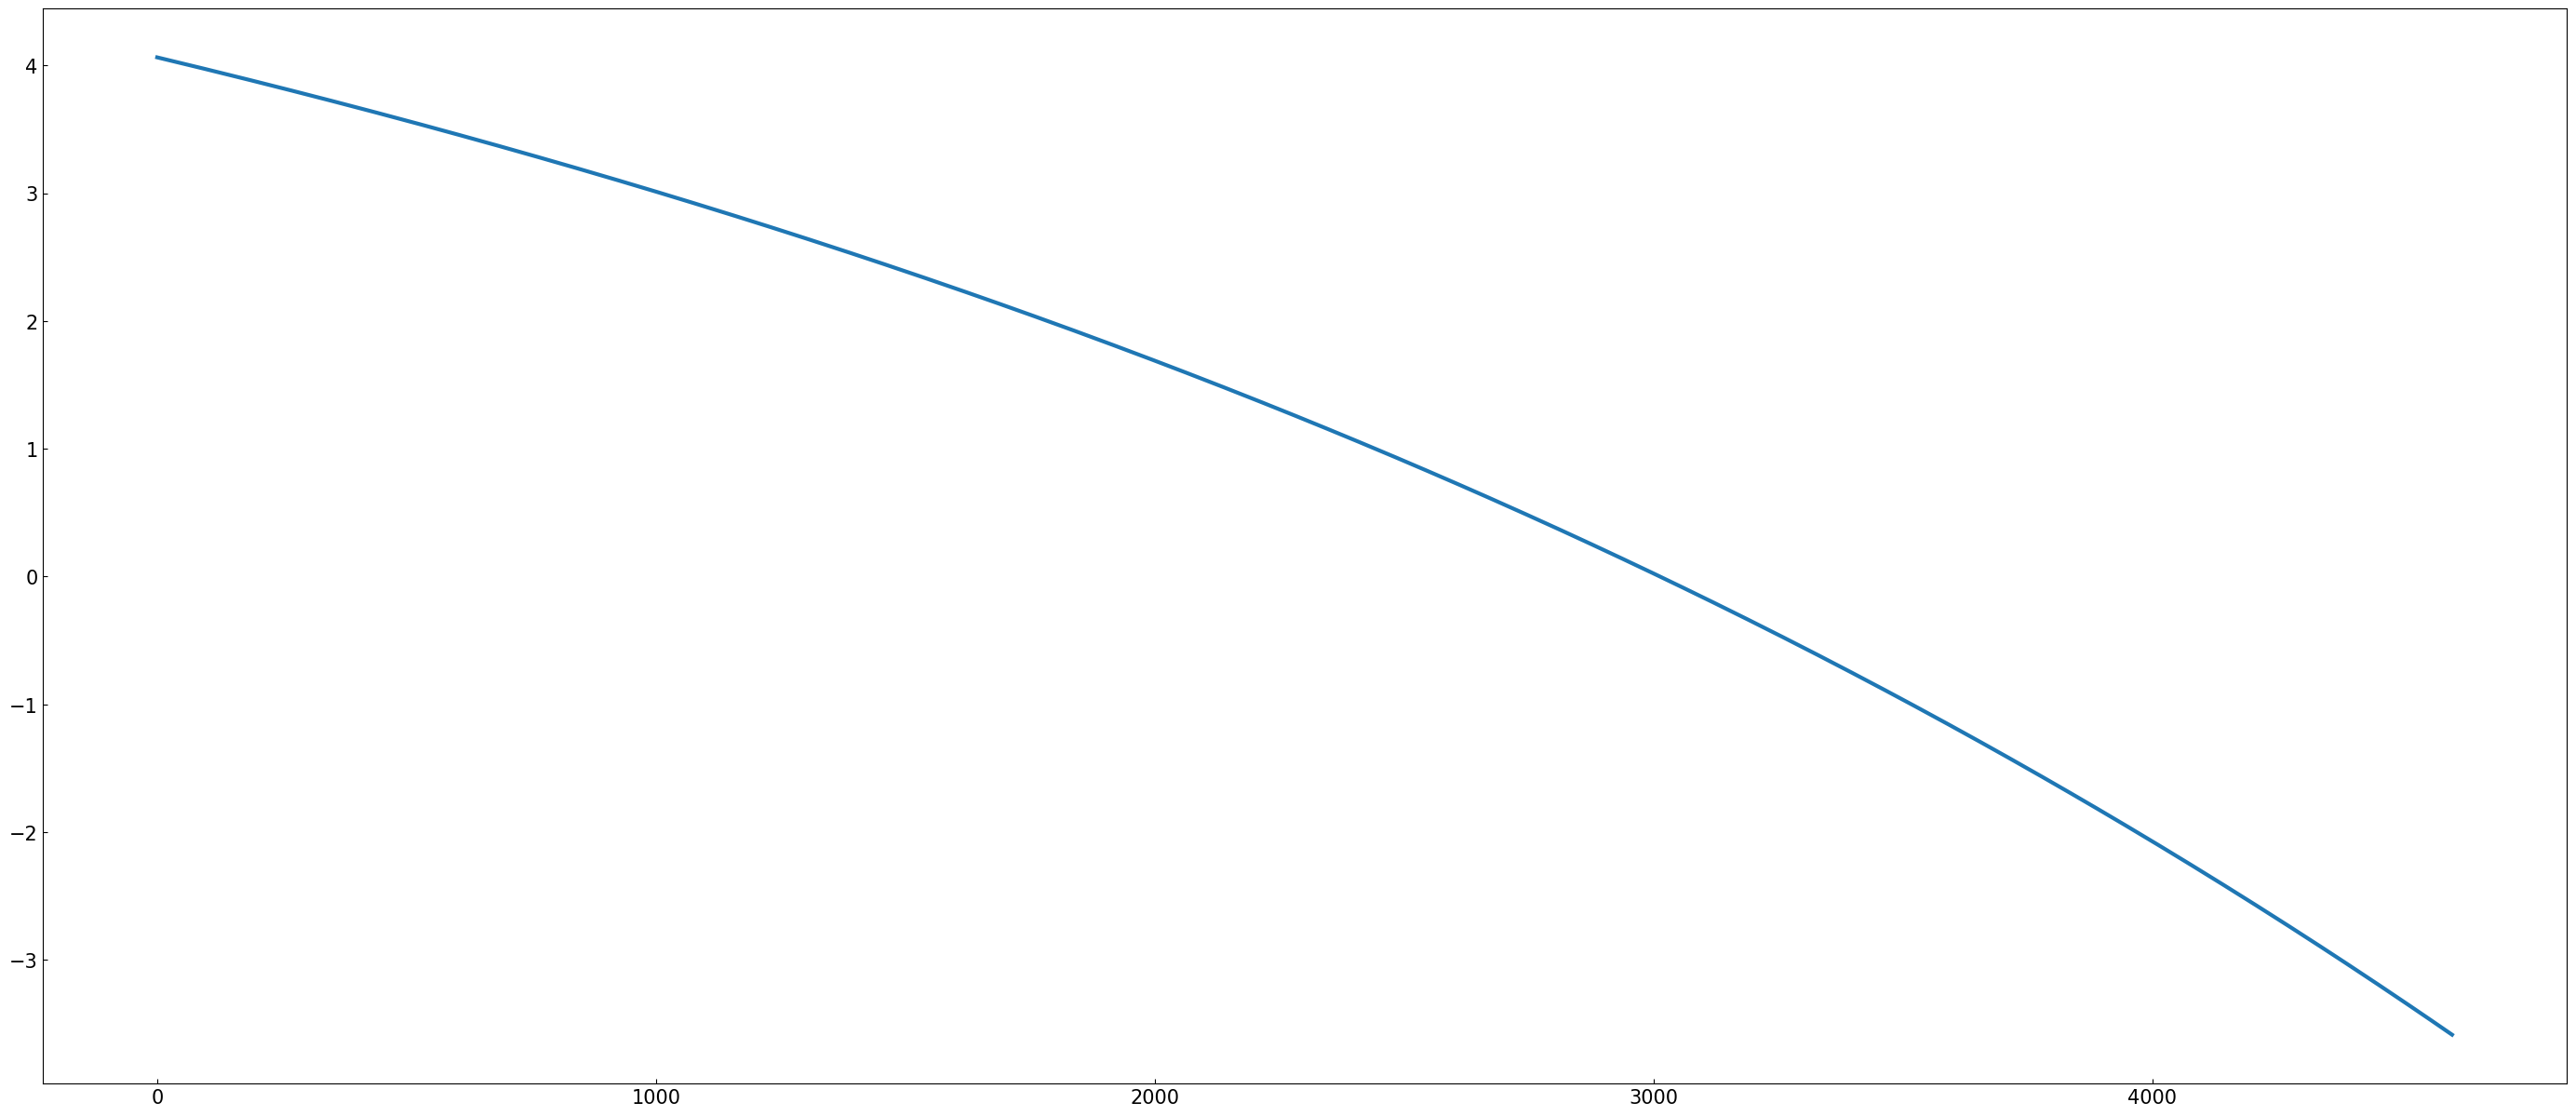

In [43]:
plt.plot(Baselines[20])

In [28]:
Master_Linear.optimize_in_axis

(None,
 0,
 0,
 0,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None)